In [1]:
from typing import Callable, List, Tuple
from pathlib import Path
import os
from argparse import Namespace
import random
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import trange

import torch
from torch import nn

import albumentations as albu
import catalyst
from catalyst.dl import SupervisedRunner

# models
import segmentation_models_pytorch as smp

# optimizer
from torch import optim
from catalyst.contrib.nn import RAdam, Lookahead

# losses
from torch.nn import CrossEntropyLoss
from catalyst.contrib.nn import LovaszLossMultiClass, LovaszLossBinary

# metrics
from catalyst.dl import IouCallback
from catalyst.dl import CriterionCallback, MetricAggregationCallback, EarlyStoppingCallback

# utilities
from pytorch_toolbelt.utils import count_parameters
import utils as u
from _torch.catalyst import SegmentationDataset, get_loaders, DataLoader, get_tensorboard_log

print(f"torch: {torch.__version__}, catalyst: {catalyst.__version__}")

SEED = 42
catalyst.utils.set_global_seed(SEED)
catalyst.utils.prepare_cudnn(deterministic=True)

torch: 1.7.0, catalyst: 20.11


In [2]:
def pre_transform(target_size):
    return [albu.Resize(target_size[0], target_size[1], p=1)]

def aug_transform():
    return [
        albu.HorizontalFlip(p=0.5),
        # albu.Downscale(scale_min=0.5, scale_max=0.95, p=0.1),
    ]  

def tensor_transforms(v2=False, long=False, add_ch_mask=False):
    
    def _long(x: torch.Tensor, **params):
        return x.long()
    
    def _ch(x: torch.Tensor, **params):
        return x.unsqueeze(0)
    # we convert it to torch.Tensor
    t = [albu.pytorch.ToTensorV2()] if v2 else [albu.pytorch.ToTensor()]
    
    # convert the mask to long for CrossEntropyLoss
    if long:
        t.append(albu.Lambda(image=None, mask=_long, p=1))
    
    if add_ch_mask:
        t.append(albu.Lambda(image=None, mask=_ch, p=1))
        
    return t

def compose(transforms_list):
    # combine all augmentations into single pipeline
    result = albu.Compose([
      item for sublist in transforms_list for item in sublist
    ])
    return result

## Arguments

In [3]:
args = Namespace()
args.gpus = os.environ['CUDA_VISIBLE_DEVICES']
args.num_workers = 16
args.is_fp16_used = False

args.batch_size = 32

args.epochs = 100
args.stopping_patience = 10
args.lr = 0.001
#args.lr_enc = 0.005
args.lr_enc = 0.001
args.lr_plateau_factor=0.25
args.lr_plateau_patience=10
args.opt_weight_decay=0.0003
#args.enc_weight_decay=0.00003
args.enc_weight_decay=0.0003

args.num_classes = 6
args.class_weights = [1/44]*args.num_classes
args.class_weights[4] = 20/44
args.class_weights[5] = 20/44

args.split_x = None
args.split_y = None
args.split_shuffle = True
args.valid = 0.05
args.patch_shape = (1006,256,1)
args.target_shape = (512,256)
args.patch_stride = (1,32,1)

args.loss_lovasz = .75
args.loss_cce = .25

# https://pypi.org/project/segmentation-models-pytorch/#encoders
args.backbone = "resnext50_32x4d" #"efficientnet-b3"
args.activation = None  # will be Identity, can be "sigmoid", "softmax2d" or Callable (like nn.Tanh)
args.pretrained = False
args.use_fpn = False
attempt = 3
args.outname = "%s_%s%s_%dto%d_attempt%d" % \
                   ("FPN" if args.use_fpn else "UNET", args.backbone, "_pre" if args.pretrained else "",
                    args.patch_shape[0], args.target_shape[0], attempt)
args.logdir = Path("./results/facies/") / args.outname

In [4]:
args.logdir

PosixPath('results/facies/UNET_resnext50_32x4d_1006to512_attempt3')

In [5]:
batch_size = args.batch_size * (2 if args.is_fp16_used else 1)

print(f"batch_size: {batch_size}")

batch_size: 32


In [6]:
!echo $CUDA_VISIBLE_DEVICES

2,3,4,5


In [7]:
device = catalyst.utils.get_device()
print(f"device: {device}")

device: cuda


In [8]:
u.save_args_to_file(args.logdir, args)

In [9]:
save_opts = {'format':'pdf', 'dpi':150, 'bbox_inches':'tight'}

## Dataset

In [10]:
ROOT = Path("/nas/home/fpicetti/datasets/seismic_facies/normalized/")

In [11]:
image = np.load(ROOT / "data_train.npz", allow_pickle=True, mmap_mode='r')['data']
label = np.load(ROOT / "labels_train.npz", allow_pickle=True, mmap_mode='r')['labels']

In [12]:
image.shape, label.shape

((1006, 782, 590), (1006, 782, 590))

In [13]:
image_train, image_test = image[:, :args.split_x, :args.split_y], image[:, args.split_x:, args.split_y:]
label_train, label_test = label[:, :args.split_x, :args.split_y], label[:, args.split_x:, args.split_y:]

In [14]:
image_train.shape, image_test.shape

((1006, 782, 590), (1006, 782, 590))

In [15]:
if args.split_x is None and args.split_y is None:
    del image, label

#### Patches in both X and Y directions

In [16]:
def swap_tuple(in_content: tuple):
    temp = list(in_content)
    temp[1], temp[2] = temp[2], temp[1]
    return tuple(temp)

In [17]:
pe_y = u.PatchExtractor(args.patch_shape, stride=args.patch_stride)
print('total ZX patches:   %d' % u.patch_extractor.count_patches(image_train.shape, pe_y.dim, pe_y.stride))
print('patch array shape: ', image_train.shape)
print('cropped volume:    ', u.patch_extractor.in_content_cropped_shape(image_train.shape, pe_y.dim, pe_y.stride))

total ZX patches:   10030
patch array shape:  (1006, 782, 590)
cropped volume:     (1006, 768, 590)


In [18]:
pe_x = u.PatchExtractor(swap_tuple(args.patch_shape), stride=swap_tuple(args.patch_stride))
print('total ZY patches:   %d' % u.patch_extractor.count_patches(image_train.shape, pe_x.dim, pe_x.stride))
print('patch array shape: ', image_train.shape)
print('cropped volume:    ', u.patch_extractor.in_content_cropped_shape(image_train.shape, pe_x.dim, pe_x.stride))


total ZY patches:   8602
patch array shape:  (1006, 782, 590)
cropped volume:     (1006, 782, 576)


In [19]:
patches_image_train = np.concatenate((pe_y.extract(image_train).reshape((-1,)+pe_y.dim),
                                      pe_x.extract(image_train).reshape((-1,)+pe_x.dim).transpose(0,1,3,2)),
                                     axis=0)
patches_label_train = np.concatenate((pe_y.extract(label_train).reshape((-1,)+pe_y.dim),
                                      pe_x.extract(label_train).reshape((-1,)+pe_x.dim).transpose(0,1,3,2)),
                                     axis=0)

print(patches_image_train.shape)
print(patches_label_train.shape)

(18632, 1006, 256, 1)
(18632, 1006, 256, 1)


#### Transforms, augmentations and loaders

In [20]:
train_transforms = compose([
    pre_transform(args.target_shape),
    aug_transform(),
    tensor_transforms(v2=True, long=True, add_ch_mask=True)])

valid_transforms = compose([
    pre_transform(args.target_shape),
    aug_transform(),
    tensor_transforms(v2=True, long=True, add_ch_mask=True)])

show_transforms  = compose([aug_transform()])

In [21]:
loaders = get_loaders(
    images=patches_image_train,
    masks=patches_label_train.astype(np.float),
    dataset = SegmentationDataset,
    random_state=SEED,
    valid_size=args.valid,
    train_transforms_fn=train_transforms,
    valid_transforms_fn=valid_transforms,
    batch_size=batch_size,
    num_workers=args.num_workers,
    split_shuffle=args.split_shuffle,
    epoch_shuffle=True,
)

## Model

In [22]:
# We will use Feature Pyramid Network with pre-trained backbone
# https://pypi.org/project/segmentation-models-pytorch/
if args.use_fpn:
    model = smp.FPN(
        classes=args.num_classes,
        in_channels=1,
        encoder_depth=5,
        encoder_name=args.backbone,
        encoder_weights='imagenet' if args.pretrained else None,
        decoder_pyramid_channels=256,
        decoder_segmentation_channels=128,
        decoder_dropout=0.3,
        decoder_merge_policy='add',
        activation=args.activation,
    )
else:
    model = smp.Unet(
        classes=args.num_classes,
        in_channels=1,
        encoder_depth=5,
        encoder_name=args.backbone,
        encoder_weights='imagenet' if args.pretrained else None,
        decoder_use_batchnorm=True,
        decoder_channels=(256, 128, 64, 32, 16),
        decoder_attention_type=None,
        activation=args.activation,
    )

In [23]:
count_parameters(model)

{'total': 31987430,
 'trainable': 31987430,
 'encoder': 22973632,
 'decoder': 9012928}

Check the initial guess

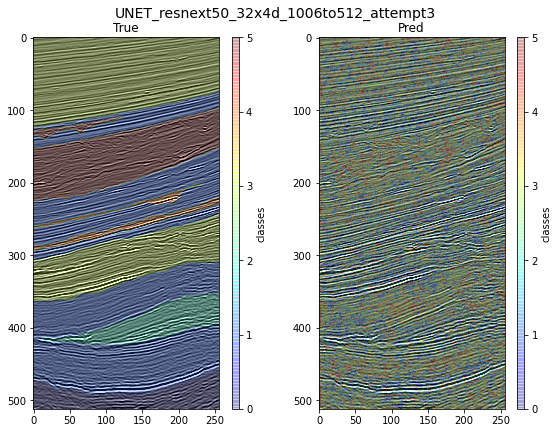

In [24]:
idx = 0
d = loaders['train'].dataset[idx]
img = d['image']
msk_true = d['mask'].unsqueeze(0)
msk_pred = model(img.unsqueeze(0))

img_ = img.detach().numpy().squeeze()
msk_true_ = msk_true.detach().numpy().squeeze()
msk_pred_ = msk_pred.detach().cpu().numpy().squeeze()

plt.figure(figsize=(8,6))
plt.subplot(121), plt.title('True')
plt.imshow(img_, cmap='gray', clim=u.plotting.clim(img_, 90))
plt.imshow(msk_true_, cmap='jet', alpha=.2), plt.colorbar(label='classes', aspect=50)
plt.subplot(122), plt.title('Pred')
plt.imshow(img_, cmap='gray', clim=u.plotting.clim(img_, 90))
plt.imshow(np.argmax(msk_pred_, axis=0), cmap='jet', alpha=.2), plt.colorbar(label='classes', aspect=50)

plt.suptitle(args.outname, fontsize=14)
plt.tight_layout(pad=.5)
plt.savefig(args.logdir/f"{idx}-th train patch with initialization", **save_opts)
plt.show()

### Losses and metrics

Classes 5 and 6 are 20 times more important w.r.t. the others (read [here](https://discourse.aicrowd.com/t/round-2-is-live/3959)).
Reweighting:

In [25]:
def f1_loss_single(targets, outputs, eps=1e-10):
    tp = torch.sum(targets * outputs)
    fp = torch.sum((1-targets) * outputs)
    fn = torch.sum(targets * (1-outputs))
    
    p = tp / (tp + fp + eps)
    r = tp / (tp + fn + eps)
    f1 = 2 * p * r / (p + r + eps)
    f1 = torch.where(torch.isnan(f1), torch.zeros_like(f1), f1)
    
    return 1 - torch.mean(f1)

In [26]:
class Lovasz(torch.nn.Module):
    def __init__(self, weight:list=None):
        super().__init__()
        self.weight = torch.tensor(weight).to(device) if weight is not None else None
        self.criterion = LovaszLossMultiClass() if self.weight is None else LovaszLossBinary()

    def forward(self, output, target): 
        if self.weight is not None:
            return sum([self.weight[i]*self.criterion(torch.softmax(output, dim=1)[:,i], target[:,i])
                        for i in range(target.size(1))])
        else:
            return self.criterion(torch.softmax(output, dim=1), target)
    
class CrossEntropy(torch.nn.Module):
    def __init__(self, weight):
        super().__init__()
        self.criterion = CrossEntropyLoss(torch.tensor(weight).to(device))

    def forward(self, output, target):
        self.criterion.weight.to(target.device)
        return self.criterion(output, target.squeeze(1).long())


class F1Loss(torch.nn.Module):
    def __init__(self, weight:list):
        super().__init__()
        self.weight = torch.tensor(weight).to(device)
        self.criterion = f1_loss_single
        
    def forward(self, output, target):
        if target.shape != output.shape:
            target = u.to_categorical(target)
        output = torch.softmax(output, dim=1)
        return sum([self.weight[i] * self.criterion(output[:,i], target[:,i])
                    for i in range(target.size(1))])

In [27]:
F1Loss(args.class_weights)(msk_pred, msk_pred)

tensor([0.0227, 0.0227, 0.0227, 0.0227, 0.4545, 0.4545], device='cuda:0')


tensor(0.7403, device='cuda:0', grad_fn=<AddBackward0>)

In [28]:
# we have multiple criterions
criterion = {
    "cce": CrossEntropy(weight=args.class_weights),
    "lov": Lovasz(weight=args.class_weights),
}
callbacks = [
    # Each criterion is calculated separately.
    CriterionCallback(
        input_key="mask",
        prefix="loss_cce",
        criterion_key="cce"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_lov",
        criterion_key="lov"
    ),
    # And only then we aggregate everything into one loss.
    MetricAggregationCallback(
        prefix="loss",
        mode="weighted_sum", # can be "sum", "weighted_sum" or "mean"
        # because we want weighted sum, we need to add scale for each loss
        metrics={
            "loss_cce": args.loss_cce,
            "loss_lov": args.loss_lovasz,
        }
    ),

    # metrics
    # F1ScoreMulticlass(input_key="mask", weights=args.class_weights)
    #DiceCallback(input_key="mask"),
    #IouCallback(input_key="mask"),
    # F1ScoreCallback(input_key="mask", prefix="f1", threshold=0.5, activation='Softmax2d')

    # stop training
    # EarlyStoppingCallback(patience=args.stopping_patience, metric="iou", minimize=False,)
]

In [29]:
criterion['lov'](msk_pred, msk_true)

tensor(0.0072, device='cuda:0', grad_fn=<AddBackward0>)

#### Optimizer and scheduling

In [30]:
# Since we use a pre-trained encoder, we will reduce the learning rate on it.
# This function removes weight_decay for biases and applies our layerwise_params
model_params = catalyst.utils.process_model_params(
    model, layerwise_params={"encoder*": dict(lr=args.lr_enc, weight_decay=args.enc_weight_decay)})

# Catalyst has new SOTA optimizers out of box
optimizer = Lookahead(RAdam(model_params, lr=args.lr, weight_decay=args.opt_weight_decay))

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                 factor=args.lr_plateau_factor,
                                                 patience=args.lr_plateau_patience)

## Train

In [31]:
# by default SupervisedRunner uses "features" and "targets",
# in our case we get "image" and "mask" keys in dataset __getitem__
runner = SupervisedRunner(device=device, input_key="image", input_target_key="mask")

In [32]:
!rm -rf {args.logdir/"*log*"}
!rm -rf {args.logdir/"checkpoints"}

In [33]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    callbacks=callbacks,
    logdir=args.logdir,
    num_epochs=args.epochs,
    #main_metric="f1",
    #minimize_metric=False,
    fp16=dict(opt_level="O1") if args.is_fp16_used else None,
    verbose=True,
)

1/100 * Epoch (train):   0% 1/553 [00:15<2:23:41, 15.62s/it, loss=0.510, loss_cce=2.012, loss_lov=0.010]

/nas/home/fpicetti/miniconda3/envs/geoml/lib/python3.8/site-packages/catalyst/contrib/nn/optimizers/radam.py:85: UserWarning:

This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)



1/100 * Epoch (train): 100% 553/553 [03:52<00:00,  2.37it/s, loss=0.036, loss_cce=0.106, loss_lov=0.012]
1/100 * Epoch (valid): 100% 29/29 [00:06<00:00,  4.64it/s, loss=0.034, loss_cce=0.099, loss_lov=0.012]
[2020-12-08 11:46:32,648] 
1/100 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/100 * Epoch 1 (train): loss=0.1076 | loss_cce=0.3911 | loss_lov=0.0131
1/100 * Epoch 1 (valid): loss=0.0362 | loss_cce=0.1089 | loss_lov=0.0120
2/100 * Epoch (train): 100% 553/553 [03:40<00:00,  2.51it/s, loss=0.023, loss_cce=0.058, loss_lov=0.012]
2/100 * Epoch (valid): 100% 29/29 [00:06<00:00,  4.61it/s, loss=0.023, loss_cce=0.056, loss_lov=0.012]
[2020-12-08 11:50:24,197] 
2/100 * Epoch 2 (_base): lr=0.0010 | momentum=0.9000
2/100 * Epoch 2 (train): loss=0.0302 | loss_cce=0.0837 | loss_lov=0.0124
2/100 * Epoch 2 (valid): loss=0.0239 | loss_cce=0.0592 | loss_lov=0.0122
3/100 * Epoch (train): 100% 553/553 [03:41<00:00,  2.50it/s, loss=0.027, loss_cce=0.070, loss_lov=0.012]
3/100 * Epoch (valid): 100%

20/100 * Epoch (train): 100% 553/553 [03:40<00:00,  2.51it/s, loss=0.019, loss_cce=0.040, loss_lov=0.012]
20/100 * Epoch (valid): 100% 29/29 [00:06<00:00,  4.50it/s, loss=0.020, loss_cce=0.045, loss_lov=0.012]
[2020-12-08 12:59:41,155] 
20/100 * Epoch 20 (_base): lr=0.0010 | momentum=0.9000
20/100 * Epoch 20 (train): loss=0.0179 | loss_cce=0.0352 | loss_lov=0.0121
20/100 * Epoch 20 (valid): loss=0.0206 | loss_cce=0.0456 | loss_lov=0.0122
21/100 * Epoch (train): 100% 553/553 [03:40<00:00,  2.51it/s, loss=0.019, loss_cce=0.039, loss_lov=0.012]
21/100 * Epoch (valid): 100% 29/29 [00:06<00:00,  4.71it/s, loss=0.017, loss_cce=0.034, loss_lov=0.012]
[2020-12-08 13:03:31,277] 
21/100 * Epoch 21 (_base): lr=0.0010 | momentum=0.9000
21/100 * Epoch 21 (train): loss=0.0183 | loss_cce=0.0368 | loss_lov=0.0121
21/100 * Epoch 21 (valid): loss=0.0180 | loss_cce=0.0364 | loss_lov=0.0119
22/100 * Epoch (train): 100% 553/553 [03:39<00:00,  2.52it/s, loss=0.017, loss_cce=0.034, loss_lov=0.012]
22/100 * E

39/100 * Epoch (train): 100% 553/553 [03:41<00:00,  2.50it/s, loss=0.017, loss_cce=0.030, loss_lov=0.012]
39/100 * Epoch (valid): 100% 29/29 [00:06<00:00,  4.53it/s, loss=0.016, loss_cce=0.028, loss_lov=0.012]
[2020-12-08 14:12:41,246] 
39/100 * Epoch 39 (_base): lr=0.0010 | momentum=0.9000
39/100 * Epoch 39 (train): loss=0.0165 | loss_cce=0.0301 | loss_lov=0.0120
39/100 * Epoch 39 (valid): loss=0.0162 | loss_cce=0.0293 | loss_lov=0.0118
40/100 * Epoch (train): 100% 553/553 [03:40<00:00,  2.50it/s, loss=0.017, loss_cce=0.031, loss_lov=0.012]
40/100 * Epoch (valid): 100% 29/29 [00:06<00:00,  4.55it/s, loss=0.016, loss_cce=0.028, loss_lov=0.012]
[2020-12-08 14:16:33,509] 
40/100 * Epoch 40 (_base): lr=0.0010 | momentum=0.9000
40/100 * Epoch 40 (train): loss=0.0162 | loss_cce=0.0290 | loss_lov=0.0120
40/100 * Epoch 40 (valid): loss=0.0162 | loss_cce=0.0294 | loss_lov=0.0118
41/100 * Epoch (train): 100% 553/553 [03:40<00:00,  2.51it/s, loss=0.017, loss_cce=0.030, loss_lov=0.013]
41/100 * E

58/100 * Epoch (train): 100% 553/553 [03:40<00:00,  2.51it/s, loss=0.016, loss_cce=0.028, loss_lov=0.012]
58/100 * Epoch (valid): 100% 29/29 [00:06<00:00,  4.61it/s, loss=0.015, loss_cce=0.026, loss_lov=0.012]
[2020-12-08 15:26:08,223] 
58/100 * Epoch 58 (_base): lr=0.0010 | momentum=0.9000
58/100 * Epoch 58 (train): loss=0.0158 | loss_cce=0.0273 | loss_lov=0.0119
58/100 * Epoch 58 (valid): loss=0.0155 | loss_cce=0.0266 | loss_lov=0.0118
59/100 * Epoch (train): 100% 553/553 [03:41<00:00,  2.49it/s, loss=0.016, loss_cce=0.027, loss_lov=0.012]
59/100 * Epoch (valid): 100% 29/29 [00:06<00:00,  4.69it/s, loss=0.015, loss_cce=0.025, loss_lov=0.012]
[2020-12-08 15:30:00,197] 
59/100 * Epoch 59 (_base): lr=0.0010 | momentum=0.9000
59/100 * Epoch 59 (train): loss=0.0156 | loss_cce=0.0267 | loss_lov=0.0119
59/100 * Epoch 59 (valid): loss=0.0155 | loss_cce=0.0264 | loss_lov=0.0119
60/100 * Epoch (train): 100% 553/553 [03:40<00:00,  2.51it/s, loss=0.015, loss_cce=0.026, loss_lov=0.012]
60/100 * E

77/100 * Epoch (train): 100% 553/553 [03:40<00:00,  2.51it/s, loss=0.015, loss_cce=0.026, loss_lov=0.012]
77/100 * Epoch (valid): 100% 29/29 [00:06<00:00,  4.40it/s, loss=0.015, loss_cce=0.024, loss_lov=0.012]
[2020-12-08 16:39:17,960] 
77/100 * Epoch 77 (_base): lr=0.0010 | momentum=0.9000
77/100 * Epoch 77 (train): loss=0.0153 | loss_cce=0.0257 | loss_lov=0.0119
77/100 * Epoch 77 (valid): loss=0.0152 | loss_cce=0.0254 | loss_lov=0.0118
78/100 * Epoch (train): 100% 553/553 [03:40<00:00,  2.51it/s, loss=0.016, loss_cce=0.027, loss_lov=0.013]
78/100 * Epoch (valid): 100% 29/29 [00:06<00:00,  4.51it/s, loss=0.015, loss_cce=0.025, loss_lov=0.011]
[2020-12-08 16:43:10,086] 
78/100 * Epoch 78 (_base): lr=0.0010 | momentum=0.9000
78/100 * Epoch 78 (train): loss=0.0154 | loss_cce=0.0257 | loss_lov=0.0119
78/100 * Epoch 78 (valid): loss=0.0152 | loss_cce=0.0257 | loss_lov=0.0118
79/100 * Epoch (train): 100% 553/553 [03:39<00:00,  2.52it/s, loss=0.016, loss_cce=0.026, loss_lov=0.012]
79/100 * E

96/100 * Epoch (train): 100% 553/553 [03:40<00:00,  2.51it/s, loss=0.014, loss_cce=0.024, loss_lov=0.011]
96/100 * Epoch (valid): 100% 29/29 [00:06<00:00,  4.56it/s, loss=0.015, loss_cce=0.024, loss_lov=0.011]
[2020-12-08 17:52:28,019] 
96/100 * Epoch 96 (_base): lr=0.0010 | momentum=0.9000
96/100 * Epoch 96 (train): loss=0.0151 | loss_cce=0.0248 | loss_lov=0.0119
96/100 * Epoch 96 (valid): loss=0.0151 | loss_cce=0.0251 | loss_lov=0.0117
97/100 * Epoch (train): 100% 553/553 [03:40<00:00,  2.51it/s, loss=0.015, loss_cce=0.025, loss_lov=0.012]
97/100 * Epoch (valid): 100% 29/29 [00:06<00:00,  4.50it/s, loss=0.015, loss_cce=0.024, loss_lov=0.011]
[2020-12-08 17:56:18,199] 
97/100 * Epoch 97 (_base): lr=0.0010 | momentum=0.9000
97/100 * Epoch 97 (train): loss=0.0151 | loss_cce=0.0248 | loss_lov=0.0119
97/100 * Epoch 97 (valid): loss=0.0151 | loss_cce=0.0250 | loss_lov=0.0118
98/100 * Epoch (train): 100% 553/553 [03:39<00:00,  2.51it/s, loss=0.015, loss_cce=0.025, loss_lov=0.012]
98/100 * E

In [34]:
history = get_tensorboard_log(args.logdir, metrics=['loss', 'loss_cce', 'loss_lov'])

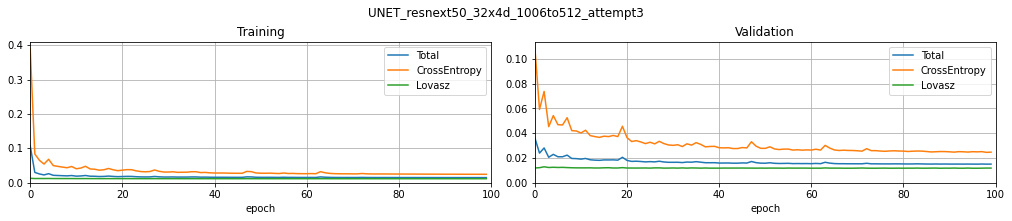

In [35]:
plt.figure(figsize=(14,3))
plt.subplot(121), plt.title('Training')
plt.plot([a.value for a in history['loss/epoch']['train']], label='Total')
plt.plot([a.value for a in history['loss_cce/epoch']['train']], label='CrossEntropy')
plt.plot([a.value for a in history['loss_lov/epoch']['train']], label='Lovasz')
plt.xlabel('epoch')
plt.xlim(0,args.epochs)
plt.ylim(0)
plt.grid(True)
plt.legend()

plt.subplot(122), plt.title('Validation')
plt.plot([a.value for a in history['loss/epoch']['valid']], label='Total')
plt.plot([a.value for a in history['loss_cce/epoch']['valid']], label='CrossEntropy')
plt.plot([a.value for a in history['loss_lov/epoch']['valid']], label='Lovasz')
plt.xlabel('epoch')
plt.xlim(0,args.epochs)
plt.ylim(0)
plt.grid(True)
plt.legend()
plt.suptitle(args.outname)

plt.tight_layout(pad=.5)
plt.savefig(args.logdir/'history', **save_opts)
plt.show()

## Model inference

Let's look at the model's predictions.


In [36]:
test_transforms  = compose([
    pre_transform(args.target_shape),
    tensor_transforms(v2=True, long=True, add_ch_mask=True)
])
final_transforms = compose([pre_transform(pe_y.dim)])

In [37]:
if args.split_x is not None or args.split_y is not None:
    patches_image_test = pe_y.extract(image_test).reshape((-1,)+pe_y.dim)
    patches_label_test = pe_y.extract(label_test).reshape((-1,)+pe_y.dim)

    print(patches_image_test.shape)
    print(patches_label_test.shape)
    
    # create test dataset
    test_dataset = SegmentationDataset(
        patches_image_test, 
        patches_label_test,
        transforms=test_transforms
    )

    infer_loader = DataLoader(
        test_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=4
    )

else:
    infer_loader = loaders['valid']

In [38]:
model.load_state_dict(torch.load(f"{args.logdir}/checkpoints/best.pth")['model_state_dict'])

<All keys matched successfully>

In [39]:
(args.split_x is not None or args.split_y is not None)

False

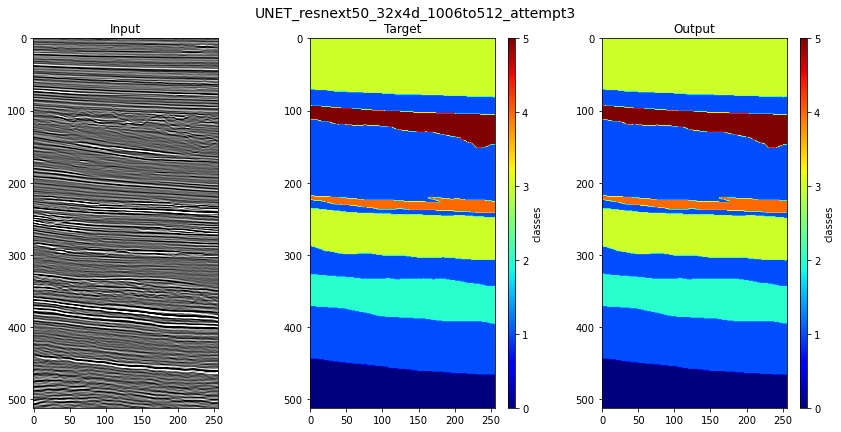

In [41]:
idx = -1
d = infer_loader.dataset[idx]
img = d['image']
msk_true = d['mask'].unsqueeze(0)
msk_pred = model(img.unsqueeze(0).to(device))

img_ = img.detach().numpy().squeeze()
msk_true_ = msk_true.detach().numpy().squeeze()
msk_pred_ = msk_pred.detach().cpu().numpy().squeeze()

plt.figure(figsize=(12,6))
plt.subplot(131), plt.title('Input'), plt.imshow(img_, cmap='gray', clim=u.plotting.clim(img_, 90))
plt.subplot(132), plt.title('Target'), plt.imshow(msk_true_, cmap='jet', clim=(0,5))
plt.colorbar(aspect=50, label='classes')
plt.subplot(133), plt.title('Output'), plt.imshow(np.argmax(msk_pred_, axis=0), cmap='jet', clim=(0,5))
plt.colorbar(aspect=50, label='classes')

plt.suptitle(args.outname, fontsize=14)
plt.tight_layout(pad=.5)
plt.savefig(args.logdir/(f"{idx}-th %s patch" % ("test" if (args.split_x is not None or args.split_y is not None) else "valid")),
           **save_opts)
plt.show()

# Aicrowd submission

Do it [here](https://www.aicrowd.com/challenges/seismic-facies-identification-challenge/submissions/new)

In [42]:
aicrowd = np.load(ROOT / "data_test_2.npz", allow_pickle=True, mmap_mode='r')['data']

In [43]:
pe_y = u.PatchExtractor(args.patch_shape, stride=(1,128,1))
patch_array_shape = u.patch_array_shape(aicrowd.shape, pe_y.dim, pe_y.stride)
print('total ZX patches :   %d' % u.patch_extractor.count_patches(aicrowd.shape, pe_y.dim, pe_y.stride))
print('original volume  : ', aicrowd.shape)
print('cropped volume   : ', u.patch_extractor.in_content_cropped_shape(aicrowd.shape, pe_y.dim, pe_y.stride))
print('patch array shape: ', patch_array_shape)

total ZX patches :   841
original volume  :  (1006, 334, 841)
cropped volume   :  (1006, 256, 841)
patch array shape:  (1, 1, 841, 1006, 256, 1)


In [44]:
pe_x = u.PatchExtractor(swap_tuple(args.patch_shape), stride=(1,1,117))
patch_array_shape = u.patch_array_shape(aicrowd.shape, pe_x.dim, pe_x.stride)
print('total ZY patches :   %d' % u.patch_extractor.count_patches(aicrowd.shape, pe_x.dim, pe_x.stride))
print('original volume  : ', aicrowd.shape)
print('cropped volume   : ', u.patch_extractor.in_content_cropped_shape(aicrowd.shape, pe_x.dim, pe_x.stride))
print('patch array shape: ', patch_array_shape)

total ZY patches :   2004
original volume  :  (1006, 334, 841)
cropped volume   :  (1006, 334, 841)
patch array shape:  (1, 334, 6, 1006, 1, 256)


In [45]:
patches_aicrowd = pe_x.extract(aicrowd).reshape((-1,)+pe_x.dim).transpose(0,1,3,2)
patches_aicrowd.shape

(2004, 1006, 256, 1)

In [46]:
test_transforms  = compose([
    pre_transform(args.target_shape),
    tensor_transforms(v2=True, long=True, add_ch_mask=True)
])
final_transforms = compose([pre_transform(args.patch_shape)])

In [47]:
aicrowd_loader = DataLoader(
    SegmentationDataset(patches_aicrowd, transforms=test_transforms),
    batch_size=1,
    shuffle=False,
    num_workers=4
)

In [48]:
aicrowd_predictions = np.vstack(list(map(
    lambda x: x["logits"].cpu().numpy(), 
    runner.predict_loader(loader=aicrowd_loader, model=model, resume=f"{args.logdir}/checkpoints/best.pth")
)))
print(aicrowd_predictions.shape)

(2004, 6, 512, 256)


In [49]:
aicrowd_result = []

for patch in aicrowd_predictions:
    patch = np.argmax(patch, 0)
    aicrowd_result.append(final_transforms(**{'image':patch.astype(float)})['image'])
aicrowd_result = np.expand_dims(np.asarray(aicrowd_result),-1)

In [50]:
aicrowd_result = pe_x.reconstruct(aicrowd_result.reshape(patch_array_shape))
aicrowd_result.shape

(1006, 334, 841)

In [51]:
aicrowd.shape

(1006, 334, 841)

We need to repeat the ZY section for 14 times along the x axis

In [52]:
last_zy = np.expand_dims(aicrowd_result[:,-1], 1)
to_be_added = np.repeat(last_zy, aicrowd.shape[1]-aicrowd_result.shape[1], axis=1)
aicrowd_result = np.concatenate((aicrowd_result, to_be_added), axis=1)
aicrowd_result.shape

(1006, 334, 841)

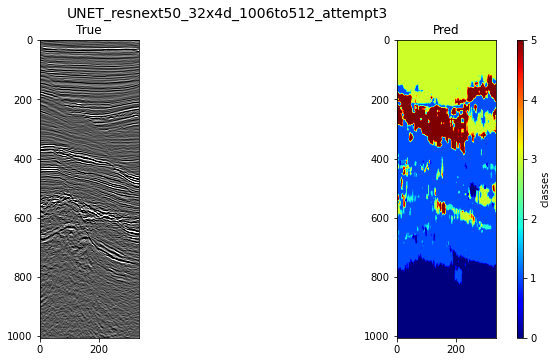

In [53]:
idx = -1
img_ = aicrowd[:,:,idx]
pred_ = aicrowd_result[:,:,idx]

plt.figure(figsize=(10,5))
plt.subplot(121), plt.title('True')
plt.imshow(img_, cmap='gray', clim=u.plotting.clim(img_, 90))
plt.subplot(122), plt.title('Pred')
plt.imshow(pred_, cmap='jet'), plt.colorbar(label='classes', aspect=50)

plt.suptitle(args.outname, fontsize=14)
plt.tight_layout(pad=.5)
plt.savefig(args.logdir/f"{idx}-th aicrowd section", **save_opts)
plt.show()

## test-time augmentations (TTA) with `hflip`

In [82]:
from pytorch_toolbelt.inference import tta

tta_model = tta.TTAWrapper(model, tta.fliplr_image2mask)

tta_runner = SupervisedRunner(
    model=tta_model,
    device=device,
    input_key="image"
)

In [83]:
tta_predictions = np.vstack(list(map(
    lambda x: x["logits"].cpu().numpy(), 
    tta_runner.predict_loader(loader=aicrowd_loader)
)))

print(tta_predictions.shape)

(2004, 6, 512, 256)


In [84]:
aicrowd_result = []

for patch in tta_predictions:
    patch = np.argmax(patch, 0)
    aicrowd_result.append(final_transforms(**{'image':patch.astype(float)})['image'])
aicrowd_result = np.expand_dims(np.asarray(aicrowd_result),-1)
aicrowd_result = pe_x.reconstruct(aicrowd_result.reshape(patch_array_shape))
aicrowd_result.shape

(1006, 334, 841)

In [32]:
last_zy = np.expand_dims(aicrowd_result[:,-1], 1)
to_be_added = np.repeat(last_zy, aicrowd.shape[1]-aicrowd_result.shape[1], axis=1)
aicrowd_result = np.concatenate((aicrowd_result, to_be_added), axis=1)
aicrowd_result.shape

(1006, 334, 841)

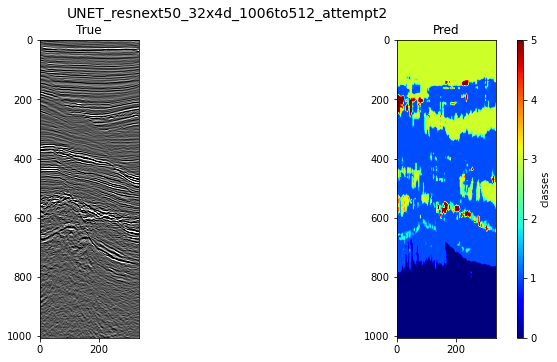

In [85]:
idx = -1
img_ = aicrowd[:,:,idx]
pred_ = aicrowd_result[:,:,idx]

plt.figure(figsize=(10,5))
plt.subplot(121), plt.title('True')
plt.imshow(img_, cmap='gray', clim=u.plotting.clim(img_, 90))
plt.subplot(122), plt.title('Pred')
plt.imshow(pred_, cmap='jet'), plt.colorbar(label='classes', aspect=50)

plt.suptitle(args.outname, fontsize=14)
plt.tight_layout(pad=.5)
plt.savefig(args.logdir/f"{idx}-th TTA aicrowd section", **save_opts)
plt.show()

### Save for submission

In [86]:
np.savez_compressed(os.path.join('facies_aicrowd_submissions', 'sub202_tta.npz'),
                    prediction=aicrowd_result.astype(np.uint8)+1)